In [1]:
import os
import sys
import numpy
import re
import time
import scipy.interpolate
from past.utils import old_div

from pipe_utils import cosmology
from pipe_utils import aux
from pipe_utils import extras
#from pipe_utils import astrometry

from astropy.cosmology import LambdaCDM
from astropy.coordinates import SkyCoord
from astropy.table import Table

import ezgal # BC03 model maker

import matplotlib.pyplot as plt


float64 = numpy.float64
int16 = numpy.int16
nstr = numpy.char
land = numpy.logical_and
lor = numpy.logical_or
sout = sys.stderr

## AB_DIR: /home/boada/Projects/planckClusters/MOSAICpipe/bpz-1.99.3/AB/


In [2]:
def KE(cosmo):
    
    # check to make sure we have defined the bpz filter path
    if not os.getenv('EZGAL_FILTERS'):
        os.environ['EZGAL_FILTERS'] = (f'{os.environ["HOME"]}/'
                                       'Projects/planckClusters/MOSAICpipe/bpz-1.99.3/FILTER/')

    model = ezgal.model('bc03_ssp_z_0.02_salp.model')
    model = model.make_exponential(1)
    model.set_cosmology(Om=cosmo.Om0, Ol=cosmo.Ode0, h=cosmo.h, w=cosmo.w(0))

    model.add_filter('g_MOSAICII.res', name='g')
    model.add_filter('r_MOSAICII.res', name='r')
    model.add_filter('i_MOSAICII.res', name='i')
    model.add_filter('z_MOSAICII.res', name='z')
    model.add_filter('K_KittPeak.res', name='K')

    # Blanton 2003 Normalization
    Mr_star = -20.44 + 5 * numpy.log10(cosmo.h) # abs mag.
    # set the normalization
    model.set_normalization('sloan_r', 0.1, Mr_star, vega=False)   
     
    return model

##################################################################
# Read both kcorrection k(z) and evolution ev(z) from BC03 model
##################################################################
def KEfit(modelfile):

    sout.write("# Getting K(z) and Ev(z) corrections from file:  %s\n" %
               modelfile)

    e = {}
    k = {}

    cols=(0, 12, 13, 14, 15, 17, 18, 19, 20)
    
    (z,
    k_g,
    k_r,
    k_i,
    k_z,
    e_g,
    e_r,
    e_i,
    e_z) = Table.read(modelfile, format='ascii').columns[cols].values()

    # K-only correction at each age SED,
    k['g'] = scipy.interpolate.interp1d(z, k_g)
    k['r'] = scipy.interpolate.interp1d(z, k_r)
    k['i'] = scipy.interpolate.interp1d(z, k_i)
    k['z'] = scipy.interpolate.interp1d(z, k_z)

    # Evolution term alone
    e['g'] = scipy.interpolate.interp1d(z, e_g)
    e['r'] = scipy.interpolate.interp1d(z, e_r)
    e['i'] = scipy.interpolate.interp1d(z, e_i)
    e['z'] = scipy.interpolate.interp1d(z, e_z)

    return k, e

######################################
# BCG Probability function
# p = 0 for M dimmer than Mlimit
# p = 1 for M brighter than Mlimit
######################################
def p_BCG(M, Mlim, b=0.4, zp=0.5):
    x = M - Mlim
    return F_BCG(x, b, zp)

################################################################
# BCG priot aux function,
#################################################################
def F_BCG(x, b=0.4, zp=0.5):

    #print "will use zp:", zp
    #print "will use b:", b
    # Recenter at 50% (0.5) or at 68.2% (0.682)
    dx = numpy.log10(-numpy.log(zp)) / b
    u = x + dx
    phi = numpy.exp(-10**(b * u))
    return phi

#######################################
# make an array with power law growth
########################################
def mklogarray(x1, x2, n):

    if x1 > 0:
        i = numpy.indices((n + 1, ))[0] * 1.0
        x = x1 * (old_div(x2, x1))**(old_div(i, n))
        #dx = x1*( (x2/x1)**(i/n) - (x2/x1)**((i-1)/n))

    elif x1 == 0:
        i = numpy.indices((n, ))[0] * 1.0 + 1
        x = numpy.zeros((n + 1, ))
        #x[1:] = x2**(i/n)
        dx = (x2 + 1)**(old_div(i, n)) - (x2 + 1)**(old_div((i - 1), n))
        x[1:] = dx.cumsum()
    else:
        print("ERROR, x < 0")
        return

    return x

#################################################
# Make histogram using xbin, gives the same
# results as numpy.histogram
#################################################
def histo(x, xbin, center=None):

    n = len(xbin) - 1

    nbin = numpy.zeros(n).astype(int16)
    for i in range(n):
        if i == 0:
            nbin[i] = len(numpy.where(land(x >= xbin[i], x <= xbin[i + 1]))[0])
        else:
            nbin[i] = len(numpy.where(land(x > xbin[i], x <= xbin[i + 1]))[0])
    # Center and reduce to n-1
    if center:
        ix = numpy.indices(xbin.shape)[0]
        i1 = ix[:-1]
        i2 = ix[1:]
        dx = xbin[i2] - xbin[i1]
        xbin = xbin[:-1] + old_div(dx, 2.0)

    return nbin, xbin

################################################################
# Bin data in y(n) acoording to x(n) using bin spacing in xbin
###############################################################
def bin_data(x, y, xbin, center=None):

    n = len(xbin) - 1
    ybin = numpy.zeros(n).astype(float64)
    for i in range(n):
        if i == 0:
            idx = numpy.where(land(x >= xbin[i], x <= xbin[i + 1]))
        else:
            idx = numpy.where(land(x > xbin[i], x <= xbin[i + 1]))
        ybin[i] = y[idx].sum()
    # Center and reduce to n-1
    if center:
        ix = numpy.indices(xbin.shape)[0]
        i1 = ix[:-1]
        i2 = ix[1:]
        dx = xbin[i2] - xbin[i1]
        xbin = xbin[:-1] + old_div(dx, 2.0)

    return ybin, xbin

In [3]:
class finder:
    def __init__(
            self,
            ctile,
            maglim=25.0,
            starlim=0.95,
            zlim=1.8,
            zo=None,
            dz=0.05,
            radius=1000.0,  # Radius in kpc
            cosmo=(0.3, 0.7, 0.7),
            zuse="ZB",  # Use ZB (Bayesian) or ML (Max Like)
            outpath='plots',
            path='./',
            evolfile="0_1gyr_hr_m62_salp_Ks.color",
            p_lim=0.4):

        # Check for environ vars
        self.home = os.environ['HOME']
        if not os.getenv('MOSAICpipe'):
            os.environ['MOSAICpipe'] = os.path.join(self.home, 'Projects',
                                                    'planckClusters',
                                                    'MOSAICpipe')
        self.MOSAICpipe = os.getenv('MOSAICpipe')

        # set path stuff
        self.ctile = ctile        
        self.outpath = outpath
        self.path = path
        self.datapath = path
        self.catsfile = os.path.join(path, ctile, ctile + "_merged.cat")
        self.probsfile = os.path.join(path, ctile, ctile + "_probs.dat")
        self.evolfile = os.path.join(self.MOSAICpipe, "LIB/evol", evolfile)
        self.rootname = os.path.join(self.datapath, self.ctile, self.ctile)
        
        # Set the cosmology now
        self.cosmo = LambdaCDM(H0=cosmo[2] * 100 , Om0=cosmo[0], Ode0=cosmo[1], Tcmb0=2.725)
        self.cosmo_init = cosmo

        # limits
        self.zlim = zlim
        self.maglim = maglim
        self.starlim = starlim
        self.dz = dz
        self.zuse = zuse
        self.radius = radius
        self.zo = zo  # Input zo for the BCG

        ##################
        ### Function calls
        
        self.read_cat()  # Read catalogs avoding, faint, high-z and 99 objects
        self.read_probs()  # Read probs function of objects from catalogs
        self.get_absmags()  # We compute Abs Mags for each object
        # Set the BCG masked to False, so we select BCGs on the first run
        self.BCG_probs = False
        # Get the BCG candidates
        self.get_BCG_candidates(p_lim=p_lim)
        
        return

    #########################################
    # Read in the big catalog of photometry
    #########################################
    def read_cat(self):
        t1 = time.time()

        cols = (0, 1, 2, 23, 27, 26, 28, 29, 30, 3, 4, 6, 7, 9, 10, 12, 13, 15,
                16, 17, 18, 19, 20, 21, 22, 31, 32, 33, 34, 35, 36)

        sout.write("# Reading cols:%s\n# Reading cats from: %s... \n" %
                   (cols, self.catsfile))
        (id, 
         ra,
         dec,
         z_b,
         odds,
         t_b,
         z_ml,
         t_ml,
         chi,
         g,
         g_err,
         r,
         r_err,
         i,
         i_err,
         z,
         z_err,
         g_bpz,
         g_berr,
         r_bpz,
         r_berr,
         i_bpz,
         i_berr,
         z_bpz,
         z_berr,
         class_star,
         a_image,
         b_image,
         theta,
         x_image,
         y_image) = Table.read(self.catsfile, format='ascii').columns[cols].values()

        ############################################
        # Choose the photo-z to use, ml or bayesian
        ############################################
        sout.write("# Will use %s redshifts\n" % self.zuse)
        if self.zuse == "ML":
            z_ph = z_ml
        elif self.zuse == "ZB":
            z_ph = z_b

        i_lim = self.maglim
        odds_lim = 0.80  # not currently used
        star_lim = self.starlim

        # Clean up according to BPZ
        sout.write("# Avoiding magnitudes -99 and 99 in BPZ \n")
        g_mask = numpy.where(lor(g_bpz == 99, g_bpz == -99), 0, 1)
        r_mask = numpy.where(lor(r_bpz == 99, r_bpz == -99), 0, 1)
        i_mask = numpy.where(lor(i_bpz == 99, i_bpz == -99), 0, 1)
        z_mask = numpy.where(lor(z_bpz == 99, z_bpz == -99), 0, 1)
        bpz_mask = g_mask * r_mask * i_mask * z_mask

        # Clean by class_star
        sout.write("# Avoiding CLASS_STAR > %s \n" % star_lim)
        mask_star = numpy.where(class_star > star_lim, 0, 1)

        # Clean up by odds
        #sout.write( "# Avoiding ODDS < %s in BPZ \n" % odds_lim)
        odds_mask = numpy.where(odds > odds_lim, 1, 0)
        odds_mask = 1

        # Avoid z> zlim objects too.
        #sout.write( "# Avoiding objects with z > %s " % self.zlim)
        zp_mask = numpy.where(z_ph > self.zlim, 0, 1)
        zp_mask = 1

        # Clean up by BPZ type
        # sout.write('# Avoiding objects with type > %s' % t)
        tp_mask = 1

        # The final 'good' mask
        mask_good = bpz_mask * odds_mask * mask_star * zp_mask * tp_mask
        idx = numpy.where(mask_good == 1)

        # Make ids a Char String in numarray
        self.id = nstr.array(id)[idx]

        # Only keep the 'good' one, avoid -99 and 99 values in BPZ mags
        self.ra = ra[idx]
        self.dec = dec[idx]
        self.z_b = z_b[idx]
        self.odds = odds[idx]

        self.z_ml = z_ml[idx]
        self.t_ml = t_ml[idx]
        self.t_b = t_b[idx]
        self.t_ml = t_ml[idx]
        self.chi = chi[idx]

        ############################################
        # Choose the photo-z to use, ml or bayesian
        ############################################
        if self.zuse == "ML":
            self.z_ph = self.z_ml
            self.type = self.t_ml
        elif self.zuse == "ZB":
            self.z_ph = self.z_b
            self.type = self.t_b

        self.g = g[idx]
        self.r = r[idx]
        self.i = i[idx]
        self.z = z[idx]
        self.g_err = g_err[idx]
        self.r_err = r_err[idx]
        self.i_err = i_err[idx]
        self.z_err = z_err[idx]

        self.g_bpz = g_bpz[idx]
        self.r_bpz = r_bpz[idx]
        self.i_bpz = i_bpz[idx]
        self.z_bpz = z_bpz[idx]
        self.g_berr = g_berr[idx]
        self.r_berr = r_berr[idx]
        self.i_berr = i_berr[idx]
        self.z_berr = z_berr[idx]

        self.class_star = class_star[idx]
        self.a_image = a_image[idx]
        self.b_image = b_image[idx]
        self.theta = theta[idx]
        self.x_image = x_image[idx]
        self.y_image = y_image[idx]

        # Color of selected galaxies
        self.gr = self.g_bpz - self.r_bpz
        self.ri = self.r_bpz - self.i_bpz
        self.iz = self.i_bpz - self.z_bpz

        # Min and and max values in RA/DEC
        self.ramin = self.ra.min()
        self.ramax = self.ra.max()
        self.decmin = self.dec.min()
        self.decmax = self.dec.max()

        self.idx_cat = idx

        sout.write(" \t Done: %s\n" % extras.elapsed_time_str(t1))
        return

    ####################################
    # Read in the the probabilty file
    ####################################
    def read_probs(self):

        # The reg expresion to compile
        regexp_point = re.compile(r"arange\("
                                  r"(?P<z1>[0-9]+.[0-9]+),"
                                  r"(?P<z2>[0-9]+.[0-9]+),"
                                  r"(?P<dz>[0-9]+.[0-9]+)\)")
        t0 = time.time()
        sout.write("# Reading probs from :%s... \n" % self.probsfile)

        # probability arrays
        probs = []
        for line in open(self.probsfile).readlines():

            fields = line.split()
            if fields[0][0] == "#":
                point = regexp_point.search(line)
                # Extract the information if a point was selected
                if point:
                    z1 = float(point.group('z1'))
                    z2 = float(point.group('z2'))
                    dz = float(point.group('dz'))
                    zx = numpy.arange(z1, z2, dz)
                continue
            probs.append(numpy.asarray(list(map(float, fields[1:]))))

        # Transform the list into an N array
        p_z = numpy.asarray(probs)

        # select same galaxies as in catalogs we just read
        self.p_z = p_z[self.idx_cat][:]
        self.zx = zx
        sout.write(" \t Done: %s\n" % extras.elapsed_time_str(t0))

        t1 = time.time()
        # Get the 1-sigma z1, z2 limits for each galaxy
        # Cumulatibe P(<z) function for each selected galaxy
        self.Psum = numpy.cumsum(self.p_z, axis=1)
        sout.write("# Getting +/- 1sigma (z1,z2) limits for each galaxy \n")
        self.z1 = self.ra * 0.0
        self.z2 = self.ra * 0.0

        # One by one in the list
        for i in range(len(self.ra)):
            i1 = numpy.where(self.Psum[i, :] >= 0.159)[0][0]
            i2 = numpy.where(self.Psum[i, :] > 0.842)[0][0]
            self.z1[i] = self.zx[i1]
            self.z2[i] = self.zx[i2]

        sout.write(" \t Done: %s\n" % extras.elapsed_time_str(t1))
        return

    ################################################
    # Get the absolute magnitudes for each object
    ################################################
    def get_absmags(self):

        # Distance modulus, dlum and dangular
        self.dlum = self.cosmo.luminosity_distance(self.z_ph).value
        self.dang = self.cosmo.angular_diameter_distance(self.z_ph).value
        self.DM = self.cosmo.distmod(self.z_ph).value

        t0 = time.time()

        # Alternatibely we can get both the kcorr and the evol from
        # the *.color file from BC03 *.ised file
        sout.write("# Computing absolute magnitudes interpolating "
                   "konly from BC03 model \n")
        k, ev = KEfit(self.evolfile)
        model = KE(self.cosmo)
        
        self.zf = 3
        
        sout.write("# Computing evolution ev(z) for each galaxy \n")
        self.ev_g = model.get_ecorrects(self.zf, filters='g', zs=self.z_ph)
        self.ev_r = model.get_ecorrects(self.zf, filters='r', zs=self.z_ph)
        self.ev_i = model.get_ecorrects(self.zf, filters='i', zs=self.z_ph)
        self.ev_z = model.get_ecorrects(self.zf, filters='z', zs=self.z_ph)
        self.ev_K = model.get_ecorrects(self.zf, filters='K', zs=self.z_ph)
        
        sout.write("# Computing k-correction k(z) for each galaxy \n")
        self.k_g = model.get_kcorrects(self.zf, filters='g', zs=self.z_ph)
        self.k_r = model.get_kcorrects(self.zf, filters='r', zs=self.z_ph)
        self.k_i = model.get_kcorrects(self.zf, filters='i', zs=self.z_ph)
        self.k_z = model.get_kcorrects(self.zf, filters='z', zs=self.z_ph)
        self.k_K = model.get_kcorrects(self.zf, filters='K', zs=self.z_ph)
        
        
#         self.ev_g = ev['g'](self.z_ph)
#         self.ev_r = ev['r'](self.z_ph)
#         self.ev_i = ev['i'](self.z_ph)
#         self.ev_z = ev['z'](self.z_ph)

        # Also get the luminosities in Msun
        # taken from http://www.ucolick.org/~cnaw/sun.html
        self.Msun = {}
        self.Msun['g'] = 5.11
        self.Msun['r'] = 4.65
        self.Msun['i'] = 4.54
        self.Msun['z'] = 4.52
        self.Msun['Ks'] = 5.14
        # ^^ http://www.astronomy.ohio-state.edu/~martini/usefuldata.html

        # Mags k-corrected
        self.Mg = self.g - self.DM - self.k_g
        self.Mr = self.r - self.DM - self.k_r
        self.Mi = self.i - self.DM - self.k_i
        self.Mz = self.z - self.DM - self.k_z
        #self.MK = self.K - self.DM - self.k_K
        
#         self.Mg = self.g - self.DM - k['g'](self.z_ph)
#         self.Mr = self.r - self.DM - k['r'](self.z_ph)
#         self.Mi = self.i - self.DM - k['i'](self.z_ph)
#         self.Mz = self.z - self.DM - k['z'](self.z_ph)

#         self.Lg = 10.0**(-0.4 * (self.Mg - self.Msun['g']))
        self.Lr = 10.0**(-0.4 * (self.Mr - self.Msun['r']))
#         self.Li = 10.0**(-0.4 * (self.Mi - self.Msun['i']))
#         self.Lz = 10.0**(-0.4 * (self.Mz - self.Msun['z']))
#         self.LK = 10.0**(-0.4 * (self.MK - self.Msun['K']))
        
#         self.Lg_err = self.Lg * self.g_err / 1.0857
#         self.Lr_err = self.Lr * self.r_err / 1.0857
#         self.Li_err = self.Li * self.i_err / 1.0857
#         self.Lz_err = self.Lz * self.z_err / 1.0857

        # Pass it up to the class
        self.evo_model = model
        self.kcorr = k
        self.evf = ev
        sout.write(" \t Done: %s\n" % extras.elapsed_time_str(t0))
        return

    ##################################################################
    # Define the sub-sample for BCGs candidates around a position
    ##################################################################
    def get_BCG_candidates(self, Mr_limit=-22.71, p_lim=1e-4):

        t0 = time.time()
        sout.write("# Computing p_BCG probabilities... ")

        # The Abs mag limit @ z=0.1 in the i-band
        _evo_model = self.evo_model.copy()
        _evo_model.set_normalization('r', 0.1, Mr_limit, vega=False)
        Mi_limit = _evo_model.get_absolute_mags(self.zf, filters='i', zs=0.1)
        
#         Mi_limit = cosmology.reobs(
#             'El_Benitez2003',
#             m=Mr_limit,
#             oldfilter="r_MOSAICII",
#             newfilter="i_MOSAICII")
#         print(Mi_limit)
        
        # Evaluate the genertic mask for BCG only onece
        if not self.BCG_probs:

            # We get the limit at the z_ph of each candidate, corrected by z=0.1    
            Mr_BCG_limit = (Mr_limit + self.ev_r - 
                            self.evo_model.get_ecorrects(self.zf, filters='r', zs=0.1))  # + self.DM_factor
            Mi_BCG_limit = (Mi_limit + self.ev_i - 
                            self.evo_model.get_ecorrects(self.zf, filters='i', zs=0.1))
                       
#             Mr_BCG_limit = Mr_limit + self.ev_r - self.evf['r'](0.1)  # + self.DM_factor
#             Mi_BCG_limit = Mi_limit + self.ev_i - self.evf['i'](0.1)  # + self.DM_factor

            # Evaluate the BCG Probability function, we
            # get the limit for each object
            self.p = p_BCG(self.Mr, Mr_BCG_limit)

            self.BCG_probs = True

            i_lim = 25.0
            star_lim = self.starlim
            p_lim = max(self.p) * 0.8
            sout.write("# Avoiding BCG_prob < %.3f in BGCs\n" % p_lim)
            mask_p = numpy.where(self.p >= p_lim, 1, 0)
            mask_g = numpy.where(self.g < i_lim + 5, 1, 0)
            mask_r = numpy.where(self.r < i_lim + 2, 1, 0)
            mask_i = numpy.where(self.i < i_lim, 1, 0)
            mask_z = numpy.where(self.z < i_lim + 1, 1, 0)
            mask_t = numpy.where(self.type <= 2.0, 1, 0)

            # Avoid freakishly bright objects, 2.5 mags brighter than the
            # M_BCG_limit
            mask_br = numpy.where(self.Mr > Mr_BCG_limit - 2.5, 1, 0)
            mask_bi = numpy.where(self.Mi > Mi_BCG_limit - 2.5, 1, 0)

            # Put a more strict cut in class_star for bcg candidates
            sout.write("# Avoiding CLASS_STAR > %s in BGCs\n" % star_lim)
            mask_star = numpy.where(self.class_star <= star_lim, 1, 0)

            # Construct the final mask now
            self.mask_BCG = (mask_t * mask_g * mask_r * mask_i * mask_z *
                             mask_br * mask_bi * mask_p * mask_star)

            sout.write(" \t Done: %s\n" % extras.elapsed_time_str(t0))

        # Select the candidates now
        idx = numpy.where(self.mask_BCG == 1)

        # And pass up to to class
        self.idx_BCG = idx
        self.id_BCG = self.id[idx]
        self.ra_BCG = self.ra[idx]
        self.dec_BCG = self.dec[idx]
        self.p_BCG = self.p[idx]
        self.z_BCG = self.z_ph[idx]
        self.t_BCG = self.type[idx]
        self.N_BCG = len(idx[0])
        self.Mi_BCG = self.Mi[idx]
        self.Mr_BCG = self.Mr[idx]
        self.DM_BCG = self.DM[idx]  # distance modulus
        self.dang_BCG = self.dang[idx]  # distance modulus

        self.zml_BCG = self.z_ml[idx]
        self.tml_BCG = self.t_ml[idx]
        self.zb_BCG = self.z_b[idx]
        self.tb_BCG = self.t_b[idx]
        self.class_BCG = self.class_star[idx]
        self.a_BCG = self.a_image[idx]
        self.b_BCG = self.b_image[idx]
        self.theta_BCG = self.theta[idx]

        # r,i-band stuff
        self.r_BCG = self.r[idx]
        self.i_BCG = self.i[idx]

        # Get the 1-sigma intervals
        self.z1_BCG = self.z1[idx]
        self.z2_BCG = self.z2[idx]

        # The r-band Luminosity of the BCGs
        self.LBCG = self.Lr[idx]

        # The distance to the candidate's position for each BCG, in arcmin
        sout.write("# Found %s BCG candidates\n" % self.N_BCG)

        return

    ########################################################
    # Modified/updated from find_clusters_ext_auto.py
    # Select galaxies around ID galaxy un redshift range
    ########################################################
    def select_members_radius(self, ra0, dec0, Mi_lim=-20.25, radius=500.0, zo=None):

#         if zo:
#             print("Will use z:%.3f for cluster" % zo)
#         else:
#             zo = self.z_ph[i]
#             print("Will use z:%.3f for cluster" % zo)
        
        # Width of the redshift shell
        dz = self.dz

        t0 = time.time()
#         sout.write("# Selecting Cluster members... Ngal, N200, R200 \n")
        
        # Get the relevant info for ith BCG
        # Calculate the M_star values
        Mstar = self.evo_model.get_absolute_mags(self.zf, filters='i', zs=zo)
        Mi_BCG = Mstar - 2.5 * numpy.log10(4.0) # 4L* galaxy at z=zo
    
        ########
        ### 1 - Select in position around ra0,dec0
        
        # Define radius in degress @ zo
        R = radius  # in kpc
        r = self.cosmo.arcsec_per_kpc_proper(zo).value / 3600 * R # in degrees
        #r = astrometry.kpc2arc(zo, R, self.cosmo_init) / 3600.  # in degrees.
        rcore = r / 2.0
        
        pos0 = SkyCoord(ra0, dec0, unit='deg', frame='icrs')
        pos1 = SkyCoord(self.ra, self.dec, unit='deg', frame='icrs')
        dist = pos0.separation(pos1).value
#         dist = astrometry.circle_distance(ra0,
#                                           dec0,
#                                           self.ra,
#                                           self.dec,
#                                           units='deg')

        mask_R = numpy.where(dist <= r, 1, 0)
        mask_rcore = numpy.where(dist <= rcore, 1, 0)
        arcmin2Mpc = self.cosmo.kpc_proper_per_arcmin(zo).value / 1000 # scale between arcmin and Mpc
        
        ########
        ### 2 - Select in redshift
        z1 = zo - dz
        z2 = zo + dz
        mask_z = numpy.where(land(self.z_ph >= z1, self.z_ph <= z2), 1, 0)

        ########
        ### 3 - Select in brightness
        Mi_lim_zo = Mi_lim + self.evf['i'](zo) - self.evf['i'](0.1)
        mask_L1 = numpy.where(self.Mi <= Mi_lim_zo, 1, 0)  # Faint  cut > 0.4L*
        mask_L2 = numpy.where(self.Mi >= Mi_BCG, 1, 0)  # Bright cut < L_BCG

        # The final selection mask, position x redshift x Luminosity
        #idx = numpy.where(mask_R * mask_L1 * mask_L2 * mask_z == 1)[0]
        idc = numpy.where(mask_rcore * mask_L1 * mask_L2 * mask_z == 1)[0]

        # Shot versions handles
        gr = self.gr
        ri = self.ri

        # Some simple 3-sigma clipping defined using r< rcore
        Nsigma = 3.0
        loop = 1
        converge = False
        while not converge:
            # The conditions to apply
            c1 = numpy.abs(gr[idc] - gr[idc].mean()) > Nsigma * numpy.std(
                gr[idc], ddof=1)
            c2 = numpy.abs(ri[idc] - ri[idc].mean()) > Nsigma * numpy.std(
                ri[idc], ddof=1)
            iclip = numpy.where(lor(
                c1, c2))[0]  # where any of the conditions fails
            if len(iclip) > 0:
                idc = numpy.delete(idc, iclip)  # Removed failed ones
                converge = False
            else:
                converge = True
            loop += 1

        # Compute the weighted average and rms
        dz = 0.5 * numpy.abs(self.z2[idc] - self.z1[idc])
        # Fix zeros
        dz[dz == 0] = 1e-5
        try:
            z_cl, z_clrms = aux.statsw(self.z_ph[idc], weight=1.0 / dz)
        except AttributeError:
            z_cl = 0 
            z_clrms = 0
#         sout.write(" \t Done: %s\n" % extras.elapsed_time_str(t0))

        # Or we can make a new mask where the condition's are true
        c1 = numpy.abs(self.gr - gr[idc].mean()) > Nsigma * numpy.std(
            gr[idc], ddof=1)
        c2 = numpy.abs(self.ri - ri[idc].mean()) > Nsigma * numpy.std(
            ri[idc], ddof=1)
        mask_cm = numpy.where(lor(c1, c2), 0, 1)  # where condition fails
        iRadius = numpy.where(
            mask_R * mask_L1 * mask_L2 * mask_z * mask_cm == 1)
        iRadius_all = numpy.where(mask_L1 * mask_L2 * mask_z * mask_cm == 1)
        Ngal = len(iRadius[0])
#         sout.write(f"# Total: {Ngal} objects selected in {radius} [kpc] around {ra0:.3} {dec0:.3}\n")

        # Pass up
        self.iRadius = iRadius
        self.arcmin2Mpc = arcmin2Mpc
        self.dist2BCG = dist
        self.Lsum = self.Lr[iRadius].sum()
        self.Ngal = Ngal
        self.z_cl = z_cl
        self.z_clerr = z_clrms
        self.rdeg = r  # in degress
        self.r1Mpc = r  # naming fix for background estimates
        self.idc = idc  # galaxies used for mean redshift
#         self.ID_BCG = ID_BCG

        # Sort indices radially for galaxies < N*R1Mpc, will be used later
        i = numpy.argsort(self.dist2BCG[iRadius_all])
        self.ix_radial = iRadius_all[0][i]

        print(zo, Ngal)
        
        
        return z_cl, z_clrms

    ##########################################
    # Compute the Background for the clusters
    ##########################################
    def background_map(self):
        ixr = self.ix_radial

        # bcg index
#         i = self.iclose

        # No back substraction
        if self.Ngal <= 2:
            self.Ngal_c = self.Ngal
#             print(color('Background -- Not enough galaxies found in cluster', 31, 5))
            return

        # Store radially ordered
        r = self.dist2BCG[ixr] * 60.0  # in arcmin
        Lr = self.Lr[ixr]  # We do in the r-band as Reyes et al

        # Bin the Ngal/Lum data in log spacing
        n = 10
        rbin = mklogarray(0.0, r.max(), n)
        Nbin, rcenter = histo(r, rbin, center='yes')
        Lbin, rcenter = bin_data(r, Lr, rbin, center='yes')

        # Compute the area in each shell
        ir = numpy.indices(rbin.shape)[0]
        ir1 = ir[:-1]
        ir2 = ir[1:]
        r1 = rbin[ir1]
        r2 = rbin[ir2]
        abin = numpy.pi * (r2**2 - r1**2)
        PN = old_div(Nbin, abin)  # Number Surface density

        # Compute the background median density both in Lum and Ngal
        # Here's is where we are going to make a couple of maps to compute the areas
        # for the background
        R1 = 3.0 * self.r1Mpc * 60.0
        R2 = r.max() # go all the way out
#         print("# Estimating Background @ r > 3mpc -- %.2f - %.2f [arcmin]" % (R1, R2))

        PN_bgr = PN[rcenter > R1]

        # Get the mean values for the Ngal and Lr profiles, which will
        # be the correction per arcmin^2
        PN_mean = numpy.mean(PN_bgr)
#         print('\tmean number of BG galaxies -- {}'.format(PN_mean))

        # Total number in background area
        N_bgr = PN_bgr.sum()

        # get the area of the background. We'll make a 'blank' image the same size as
        # our input image and then sum over the pixels that are either in or out of
        # the cluster region.
        # cluster location
        a, b = round(self.x_image[self.iclose]), round(self.y_image[self.iclose])
        # size of the image
        n = self.jpg_array.shape[0]
        # cluster radius in arcseconds converted to pixels.
        r = R1 * 60 / self.pixscale

        # create pixel grid
        y,x = numpy.ogrid[-a:n-a, -b:n-b]
        # mask the cluster region
        mask = x*x + y*y <= r*r
        # create new 'bool' image
        img_array = numpy.ones((n, n), dtype='bool')
        # the cluster region becomes 'false' or zero
        img_array[mask] = False

        # sum the background region gives the number of pixels. Multiply by the pixel
        # scale to get the total area. Convert to arcminutes.
        area_bgr = img_array.sum() * self.pixscale / 60

        # Get the correction for Number of galaxies and Luminosoty
        # For R200 we need to recompute R200 and N200 based on new
        # R200 value.
        area_r1Mpc = math.pi * (self.r1Mpc * 60.)**2  # in arcmin2
        # use the inverse of the cluster mask to find the cluster area
        area_r1mpc = (n**2 - img_array.sum()) * self.pixscale / 60

        self.Ngal_c = self.Ngal - PN_mean * area_r1Mpc
        if self.Ngal_c < 0:
            self.Ngal_c = 0.0

        self.d_Ngal_c2 = self.Ngal_c + (
            (old_div(area_r1Mpc, area_bgr))**2) * N_bgr

        # Avoid sqrt of negative number
        if self.d_Ngal_c2 < 0:
            self.d_Ngal_c = 0
        else:
            self.d_Ngal_c = math.sqrt(self.Ngal_c + (
                (old_div(area_r1Mpc, area_bgr))**2) * N_bgr)

        return

    # Get the nearest object in catalog
    def get_nearest(self, x, y):
        distance = numpy.sqrt((self.x_image - x)**2 + (self.y_image - y)**2)
        self.iclose = numpy.argmin(distance)
        self.ID = self.id[self.iclose]
        return

In [9]:
ctile = 'PSZ2_G305.76+44.79'
#ctile = 'PSZ2_G043.44-41.27'
#ctile = 'PSZ2_G029.66-47.63'
path = f'/home/boada/Projects/planckClusters/data/proc2/{ctile}'

radius = 1000.0

f = finder(
    ctile,
    maglim=26.0,
    starlim=0.95,
    zlim=1.8,
    dz=0.08,
    radius=radius,
    cosmo=(0.3, 0.7, 0.7),
    zuse="ZB", # Use ZB (Bayesian) or ML (Max Like)
    outpath='plots',
    path=path,
    evolfile="0_1gyr_hr_m62_salp_Ks.color",
    p_lim=0.4)

# Reading cols:(0, 1, 2, 23, 27, 26, 28, 29, 30, 3, 4, 6, 7, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 31, 32, 33, 34, 35, 36)
# Reading cats from: /home/boada/Projects/planckClusters/data/proc2/PSZ2_G305.76+44.79/PSZ2_G305.76+44.79/PSZ2_G305.76+44.79_merged.cat... 
# Will use ZB redshifts
# Avoiding magnitudes -99 and 99 in BPZ 
# Avoiding CLASS_STAR > 0.95 
 	 Done: Elapsed time: 0h 0m 1.5794s
# Reading probs from :/home/boada/Projects/planckClusters/data/proc2/PSZ2_G305.76+44.79/PSZ2_G305.76+44.79/PSZ2_G305.76+44.79_probs.dat... 
 	 Done: Elapsed time: 0h 0m 1.2340s
# Getting +/- 1sigma (z1,z2) limits for each galaxy 
 	 Done: Elapsed time: 0h 0m 0.3140s
# Computing absolute magnitudes interpolating konly from BC03 model 
# Getting K(z) and Ev(z) corrections from file:  /home/boada/Projects/planckClusters/MOSAICpipe/LIB/evol/0_1gyr_hr_m62_salp_Ks.color


/home/boada/.local/lib/python3.6/site-packages/ezgal/data/models/bc03_ssp_z_0.02_salp.model


# Computing evolution ev(z) for each galaxy 
# Computing k-correction k(z) for each galaxy 
 	 Done: Elapsed time: 0h 0m 14.6752s
# Computing p_BCG probabilities... # Avoiding BCG_prob < 0.794 in BGCs
# Avoiding CLASS_STAR > 0.95 in BGCs
 	 Done: Elapsed time: 0h 0m 0.3686s
# Found 22 BCG candidates


In [10]:

# for PSZ2 305... 
ra, dec = 194.97675983910088, -18.033013763484625

# for PSZ2 043.44...
#ra, dec = 324.1836114621581, -10.296616587968675

# for PSZ2 029.66
#ra, dec = 326.4342608419447, -21.780223996771788

gals = []
for z in numpy.arange(0.01, 1, 0.02):
    z_cl, z_err = f.select_members_radius(ra, dec,
                                         radius=radius,
                                         zo=z)
    gals.append(f.Ngal)
    #f.background_map()
    #print(f.Ngal_c)

0.01 91
0.03 118
0.049999999999999996 88
0.06999999999999999 64
0.08999999999999998 51
0.10999999999999997 42
0.12999999999999998 37
0.15 29
0.16999999999999998 28
0.18999999999999997 24
0.20999999999999996 18
0.22999999999999998 18
0.24999999999999997 18
0.26999999999999996 17
0.29 13
0.30999999999999994 12
0.32999999999999996 15
0.35 18
0.36999999999999994 18
0.38999999999999996 15
0.4099999999999999 23
0.42999999999999994 29
0.44999999999999996 26
0.4699999999999999 29
0.48999999999999994 44
0.5099999999999999 53
0.5299999999999999 53
0.5499999999999999 66
0.57 67
0.59 72
0.6099999999999999 74
0.6299999999999999 78
0.6499999999999999 83
0.6699999999999999 78
0.69 83
0.7099999999999999 77
0.7299999999999999 72
0.7499999999999999 68
0.7699999999999999 63
0.7899999999999999 51
0.8099999999999998 46
0.8299999999999998 30
0.8499999999999999 19
0.8699999999999999 14
0.8899999999999999 11
0.9099999999999999 7
0.9299999999999998 6
0.9499999999999998 6
0.9699999999999999 1
0.9899999999999999

/home/boada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:527: RuntimeWarning: Mean of empty slice.
/home/boada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:529: RuntimeWarning: Mean of empty slice.
# warning: statsw weight sum is zero
/home/boada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:552: RuntimeWarning: Mean of empty slice.
/home/boada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:554: RuntimeWarning: Mean of empty slice.


Text(0, 0.5, 'Ngal')

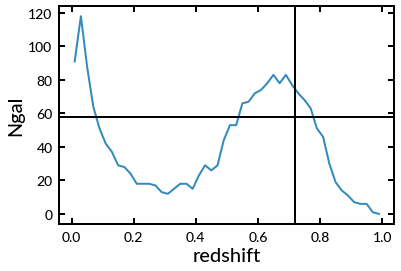

In [11]:
plt.figure()
plt.plot(numpy.arange(0.01, 1, 0.02), gals)
plt.axvline(0.72)
plt.axhline(58)
plt.xlabel('redshift')
plt.ylabel('Ngal')